In [1]:
%matplotlib inline


# MaD DiGait Pipeline

This pipeline showcases the current gait analysis pipeline used by the MaD-Lab with all required steps:
Preprocessing -> Stride Segmentation -> Event Detection -> Trajectory Reconstruction -> Parameter Estimation

This should serve as a compact example that can be copied and pasted into new projects.
For more details on the individual steps have a look at the extended examples and the documentation of the main classes:

- `Preprocessing <example_preprocessing>`
- `Stride Segmentation (BarthDTW) <example_barth_stride_segmentation>`
- `Event Detection (RamppEventDetection) <example_rampp_event_detection>`
- `Trajectory Reconstruction (double Integration) <example_preprocessing>`
- `Temporal Parameters <example_temporal_parameters>` and `Spatial Parameters <example_spatial_parameters>`


In [2]:
pip install gaitmap

Note: you may need to restart the kernel to use updated packages.


## Load example data



In [52]:
import numpy as np
import pandas as pd 

np.random.seed(0)

example_dataset = pd.read_csv('16thmay2.csv', index_col=False)
sampling_rate_hz = 50

from gaitmap.preprocessing import sensor_alignment

In [53]:
type(example_dataset)

pandas.core.frame.DataFrame

In [54]:
example_dataset.head(1)

,Time,Device name设备名称,Acceleration X(g),Acceleration Y(g),Acceleration Z(g),Angular velocity X(°/s),Angular velocity Y(°/s),Angular velocity Z(°/s),Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.097,-0.992,0.038,1.465,-0.793,0.671,-87.973,5.521,113.698,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768


In [55]:
renamed = {'Device name设备名称':'Device name','Acceleration X(g)':'acc_x','Acceleration Y(g)':'acc_y','Acceleration Z(g)':'acc_z',
'Angular velocity X(°/s)':'gyr_x','Angular velocity Y(°/s)':'gyr_y','Angular velocity Z(°/s)':'gyr_z'}

example_dataset = example_dataset.rename(columns=renamed)
example_dataset.head()

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.097,-0.992,0.038,1.465,-0.793,0.671,-87.973,5.521,113.698,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768
1,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.098,-0.990,0.040,1.526,-0.671,0.366,-87.946,5.526,113.741,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768
2,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.005,0.031,0.244,-1.282,-0.549,0.341,-88.088,152.281,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193
3,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.031,0.244,-0.977,-0.244,0.659,-88.110,151.990,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193
4,14:51:34.530,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.030,0.305,-0.488,0.000,0.829,-88.121,151.853,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193


In [56]:
example_dataset.drop(['Angle X(°)','Angle Y(°)','Angle Z(°)','Magnetic field X(ʯt)','Magnetic field Y(ʯt)','Magnetic field Z(ʯt)','Temperature(℃)','Quaternions 0()','Quaternions 1()','Quaternions 2()','Quaternions 3()'],axis=1,inplace=True)
example_dataset

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
0,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.097,-0.992,0.038,1.465,-0.793,0.671
1,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.098,-0.990,0.040,1.526,-0.671,0.366
2,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.005,0.031,0.244,-1.282,-0.549
3,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.031,0.244,-0.977,-0.244
4,14:51:34.530,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.030,0.305,-0.488,0.000
...,...,...,...,...,...,...,...,...
2973,14:52:04.349,WT901BLE68(cc:c4:7a:a1:fe:ea),1.001,0.394,0.044,45.959,14.099,-57.190
2974,14:52:04.409,WT901BLE68(cc:c4:7a:a1:fe:ea),1.025,0.285,0.082,48.096,17.517,-77.698
2975,14:52:04.409,WT901BLE68(cc:c4:7a:a1:fe:ea),1.311,-1.541,0.053,12.878,59.875,-122.559
2976,14:52:04.438,WT901BLE68(cc:c4:7a:a1:fe:ea),1.236,-0.838,0.174,41.199,55.298,-146.362


In [57]:
example_dataset.columns

Index(['Time', 'Device name', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y',
       'gyr_z'],
      dtype='object')

In [58]:
# Function to convert DataFrame to dictionary of DataFrames
def df_to_dict_of_dfs(df):
    device_names = df['Device name'].unique()
    dfs_dict = {}

    for device_name in device_names:
        device_df = df[df['Device name'] == device_name].copy()
        device_df.drop(columns='Device name', inplace=True)
        dfs_dict[device_name] = device_df.reset_index(drop=True)
    
    return dfs_dict

# Convert DataFrame to dictionary of DataFrames
dfs_dict = df_to_dict_of_dfs(example_dataset)
dfs_dict

{'WT901BLE68(d8:09:5a:ca:b6:e0)':                Time  acc_x  acc_y  acc_z  gyr_x  gyr_y  gyr_z
 0      14:51:34.493 -0.097 -0.992  0.038  1.465 -0.793  0.671
 1      14:51:34.493 -0.098 -0.990  0.040  1.526 -0.671  0.366
 2      14:51:34.532 -0.098 -0.993  0.038  1.526 -0.488  0.122
 3      14:51:34.532 -0.099 -0.994  0.035  1.770 -0.427  0.061
 4      14:51:34.534 -0.098 -0.994  0.036  2.136 -0.427 -0.061
 ...             ...    ...    ...    ...    ...    ...    ...
 1485   14:52:03.864 -0.225 -0.986  0.053 -2.197 -2.319  7.019
 1486   14:52:03.894 -0.146 -0.973  0.042  0.549  1.892 -1.038
 1487   14:52:03.894 -0.147 -0.978  0.036 -3.479 -2.625  5.554
 1488   14:52:03.925 -0.155 -0.986  0.039 -2.258 -3.357  5.005
 1489   14:52:03.925 -0.154 -0.985  0.047 -2.991 -2.625  4.761
 
 [1490 rows x 7 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':                Time  acc_x  acc_y  acc_z   gyr_x   gyr_y    gyr_z
 0      14:51:34.498  0.995  0.005  0.031   0.244  -1.282   -0.549
 1      14:51:34

In [59]:

# Print the dictionary of DataFrames
for device_name, device_df in dfs_dict.items():
    print(f"Device Name: {device_name}")
    print(device_df)
    print()

Device Name: WT901BLE68(d8:09:5a:ca:b6:e0)
               Time  acc_x  acc_y  acc_z  gyr_x  gyr_y  gyr_z
0      14:51:34.493 -0.097 -0.992  0.038  1.465 -0.793  0.671
1      14:51:34.493 -0.098 -0.990  0.040  1.526 -0.671  0.366
2      14:51:34.532 -0.098 -0.993  0.038  1.526 -0.488  0.122
3      14:51:34.532 -0.099 -0.994  0.035  1.770 -0.427  0.061
4      14:51:34.534 -0.098 -0.994  0.036  2.136 -0.427 -0.061
...             ...    ...    ...    ...    ...    ...    ...
1485   14:52:03.864 -0.225 -0.986  0.053 -2.197 -2.319  7.019
1486   14:52:03.894 -0.146 -0.973  0.042  0.549  1.892 -1.038
1487   14:52:03.894 -0.147 -0.978  0.036 -3.479 -2.625  5.554
1488   14:52:03.925 -0.155 -0.986  0.039 -2.258 -3.357  5.005
1489   14:52:03.925 -0.154 -0.985  0.047 -2.991 -2.625  4.761

[1490 rows x 7 columns]

Device Name: WT901BLE68(cc:c4:7a:a1:fe:ea)
               Time  acc_x  acc_y  acc_z   gyr_x   gyr_y    gyr_z
0      14:51:34.498  0.995  0.005  0.031   0.244  -1.282   -0.549
1      14:51

In [60]:
from gaitmap.utils.datatype_helper import get_multi_sensor_names
get_multi_sensor_names(dfs_dict)

dict_keys(['WT901BLE68(d8:09:5a:ca:b6:e0)', 'WT901BLE68(cc:c4:7a:a1:fe:ea)'])

In [61]:
from gaitmap.utils.datatype_helper import is_sensor_data

is_sensor_data(dfs_dict, frame="sensor")


'multi'

In [62]:
is_sensor_data(dfs_dict['WT901BLE68(d8:09:5a:ca:b6:e0)'], frame="sensor")

'single'

## Preprocessing
Fix the alignment between the sensor coordinate system and the gaitmap coordinate system.
This will be different for each sensor position and recording.



In [63]:
from scipy.spatial.transform import Rotation

# For multiple sensors, we write down the rotation matrices for each sensor into a dict
rotation_matrices = {
      'WT901BLE68(d8:09:5a:ca:b6:e0)': Rotation.from_matrix(np.array([[ 0, 1,  0], [ 0,  0,  1], [1,  0,  0]])),
      'WT901BLE68(cc:c4:7a:a1:fe:ea)': Rotation.from_matrix(np.array([[ 0,  -1,  0], [ 0,  0, -1], [1,  0,  0]]))
}
from gaitmap.utils.rotations import rotate_dataset

# We assume `data` has two sensors with the same names as in the dict above
data = rotate_dataset(dfs_dict, rotation_matrices)
data

{'WT901BLE68(d8:09:5a:ca:b6:e0)':                Time  acc_x  acc_y  acc_z  gyr_x  gyr_y  gyr_z
 0      14:51:34.493 -0.992  0.038 -0.097 -0.793  0.671  1.465
 1      14:51:34.493 -0.990  0.040 -0.098 -0.671  0.366  1.526
 2      14:51:34.532 -0.993  0.038 -0.098 -0.488  0.122  1.526
 3      14:51:34.532 -0.994  0.035 -0.099 -0.427  0.061  1.770
 4      14:51:34.534 -0.994  0.036 -0.098 -0.427 -0.061  2.136
 ...             ...    ...    ...    ...    ...    ...    ...
 1485   14:52:03.864 -0.986  0.053 -0.225 -2.319  7.019 -2.197
 1486   14:52:03.894 -0.973  0.042 -0.146  1.892 -1.038  0.549
 1487   14:52:03.894 -0.978  0.036 -0.147 -2.625  5.554 -3.479
 1488   14:52:03.925 -0.986  0.039 -0.155 -3.357  5.005 -2.258
 1489   14:52:03.925 -0.985  0.047 -0.154 -2.625  4.761 -2.991
 
 [1490 rows x 7 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':                Time  acc_x  acc_y  acc_z   gyr_x    gyr_y   gyr_z
 0      14:51:34.498 -0.005 -0.031  0.995   1.282    0.549   0.244
 1      14:51:34

## Stride Segmentation
In this step the continuous datastream is segmented into individual strides.
For longer datasets it might be required to first identify segments of walking to reduce the chance of
false-positives.



In [64]:
from gaitmap.stride_segmentation import BarthDtw
from gaitmap.utils.coordinate_conversion import convert_to_fbf

dtw = BarthDtw()
# Convert data to foot-frame
bf_data = convert_to_fbf(data, left_like="WT901BLE68(d8:09:5a:ca:b6:e0)", right_like="WT901BLE68(cc:c4:7a:a1:fe:ea)")
dtw = dtw.segment(data=bf_data, sampling_rate_hz=sampling_rate_hz)

In [65]:
segmented_strides = dtw.stride_list_
segmented_strides

{'WT901BLE68(d8:09:5a:ca:b6:e0)':       start   end
 s_id             
 0        88   201
 1       201   294
 2       294   382
 3       385   492
 4       492   584
 5       585   694
 6       694   737
 7       890   988
 8       988  1094
 9      1094  1195
 10     1195  1302
 11     1302  1403
 12     1403  1451,
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':       start   end
 s_id             
 0        10    65
 1        65   122
 2       122   221
 3       221   310
 4       310   412
 5       412   516
 6       516   619
 7       619   655
 8       812   907
 9       907  1007
 10     1007  1114
 11     1114  1221
 12     1221  1326
 13     1326  1442
 14     1442  1486}

In [66]:
dtw_warping_path = dtw.paths_
dtw_warping_path

{'WT901BLE68(d8:09:5a:ca:b6:e0)': [array([[  0,  92],
         [  1,  93],
         [  2,  94],
         [  3,  95],
         [  3,  96],
         [  3,  97],
         [  3,  98],
         [  3,  99],
         [  3, 100],
         [  3, 101],
         [  3, 102],
         [  3, 103],
         [  3, 104],
         [  4, 105],
         [  4, 106],
         [  4, 107],
         [  5, 108],
         [  6, 109],
         [  7, 110],
         [  8, 110],
         [  9, 110],
         [ 10, 110],
         [ 11, 110],
         [ 12, 111],
         [ 13, 112],
         [ 14, 113],
         [ 15, 114],
         [ 16, 115],
         [ 17, 116],
         [ 17, 117],
         [ 17, 118],
         [ 17, 119],
         [ 17, 120],
         [ 17, 121],
         [ 17, 122],
         [ 17, 123],
         [ 17, 124],
         [ 17, 125],
         [ 17, 126],
         [ 17, 127],
         [ 18, 128],
         [ 18, 129],
         [ 18, 130],
         [ 18, 131],
         [ 18, 132],
         [ 19, 133],
 

In [67]:
bf_data

{'WT901BLE68(d8:09:5a:ca:b6:e0)':       acc_pa  acc_ml  acc_si  gyr_pa  gyr_ml  gyr_si
 0     -0.992   0.038   0.097   0.793  -0.671  -1.465
 1     -0.990   0.040   0.098   0.671  -0.366  -1.526
 2     -0.993   0.038   0.098   0.488  -0.122  -1.526
 3     -0.994   0.035   0.099   0.427  -0.061  -1.770
 4     -0.994   0.036   0.098   0.427   0.061  -2.136
 ...      ...     ...     ...     ...     ...     ...
 1485  -0.986   0.053   0.225   2.319  -7.019   2.197
 1486  -0.973   0.042   0.146  -1.892   1.038  -0.549
 1487  -0.978   0.036   0.147   2.625  -5.554   3.479
 1488  -0.986   0.039   0.155   3.357  -5.005   2.258
 1489  -0.985   0.047   0.154   2.625  -4.761   2.991
 
 [1490 rows x 6 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':       acc_pa  acc_ml  acc_si  gyr_pa   gyr_ml  gyr_si
 0     -0.005   0.031  -0.995   1.282   -0.549   0.244
 1     -0.006   0.031  -0.995   0.977   -0.244   0.244
 2     -0.006   0.030  -0.995   0.488   -0.000   0.305
 3     -0.005   0.030  -0.996   0.061 

In [68]:
dtw

BarthDtw(conflict_resolution=True, find_matches_method='find_peaks', max_cost=4.0, max_match_length_s=3.0, max_signal_stretch_ms=None, max_template_stretch_ms=None, memory=None, min_match_length_s=0.6, resample_template=True, snap_to_min_axis='gyr_ml', snap_to_min_win_ms=300, template=BarthOriginalTemplate(scaling=FixedScaler(offset=0, scale=500.0), use_cols=None))

## Event detection
For each identified stride, we now identify important stride events.



In [69]:
from gaitmap.event_detection import RamppEventDetection

ed = RamppEventDetection()
ed = ed.detect(data=bf_data, stride_list=dtw.stride_list_, sampling_rate_hz=sampling_rate_hz)

## Trajectory Reconstruction
Using the identified events the trajectory of each stride is reconstructed using double integration starting from the
`min_vel` event of each stride.



In [70]:
from gaitmap.trajectory_reconstruction import StrideLevelTrajectory

trajectory = StrideLevelTrajectory()
trajectory = trajectory.estimate(
    data=data, stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz
)

## Temporal Parameter Calculation
Now we have all information to calculate relevant temporal parameters (like stride time)



In [71]:
from gaitmap.parameters import TemporalParameterCalculation

temporal_paras = TemporalParameterCalculation()
temporal_paras = temporal_paras.calculate(stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz)

## Spatial Parameter Calculation
Like the temporal parameters, we can also calculate the spatial parameter.



In [72]:
from gaitmap.parameters import SpatialParameterCalculation

spatial_paras = SpatialParameterCalculation()
spatial_paras = spatial_paras.calculate(
    stride_event_list=ed.min_vel_event_list_,
    positions=trajectory.position_,
    orientations=trajectory.orientation_,
    sampling_rate_hz=sampling_rate_hz,
)

## Inspecting the Results
The class of each step allows you to inspect all results in detail.
Here we will just print and plot the most important once.
Note, that the plots below are for sure not the best way to represent results!



In [73]:
import matplotlib.pyplot as plt

print(
    f"The following number of strides were identified and parameterized for each sensor: {({k: len(v) for k, v in ed.min_vel_event_list_.items()})}"
)

The following number of strides were identified and parameterized for each sensor: {'WT901BLE68(d8:09:5a:ca:b6:e0)': 9, 'WT901BLE68(cc:c4:7a:a1:fe:ea)': 11}


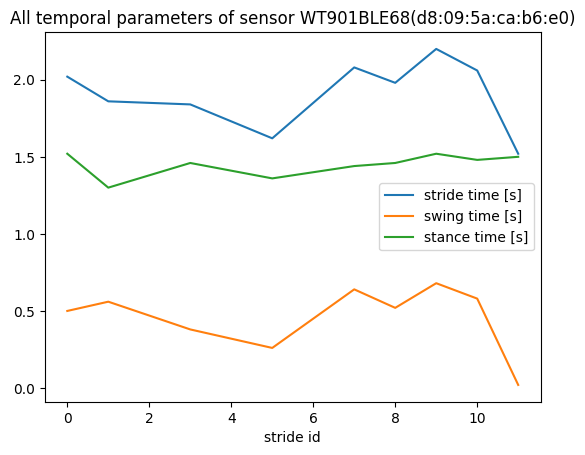

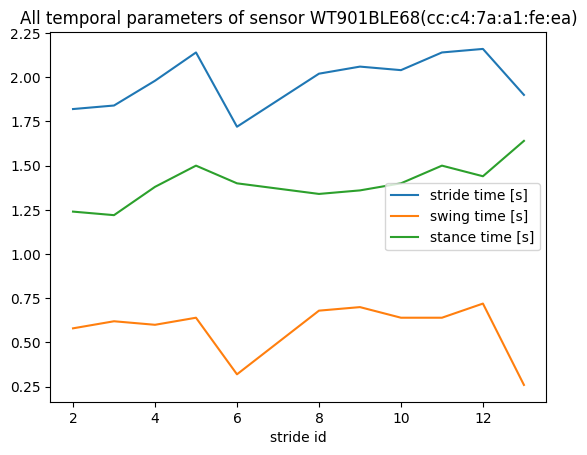

In [74]:
for k, v in temporal_paras.parameters_pretty_.items():
    v.plot()
    plt.title(f"All temporal parameters of sensor {k}")

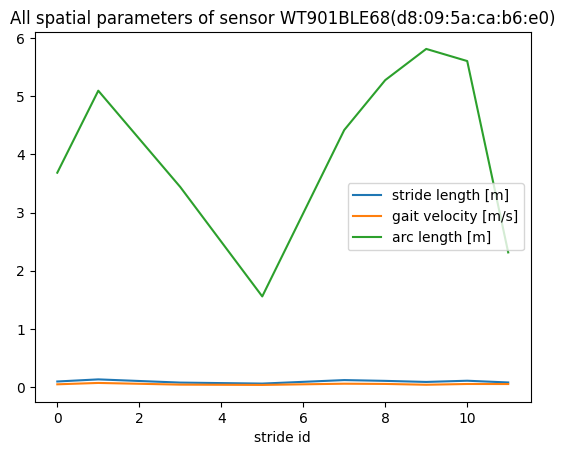

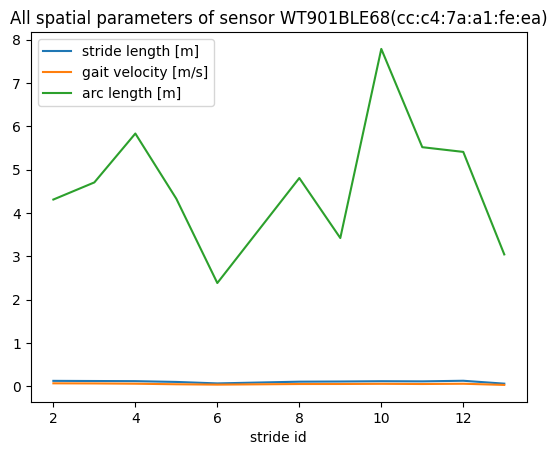

In [75]:
for k, v in spatial_paras.parameters_pretty_.items():
    v[["stride length [m]", "gait velocity [m/s]", "arc length [m]"]].plot()
    plt.title(f"All spatial parameters of sensor {k}")

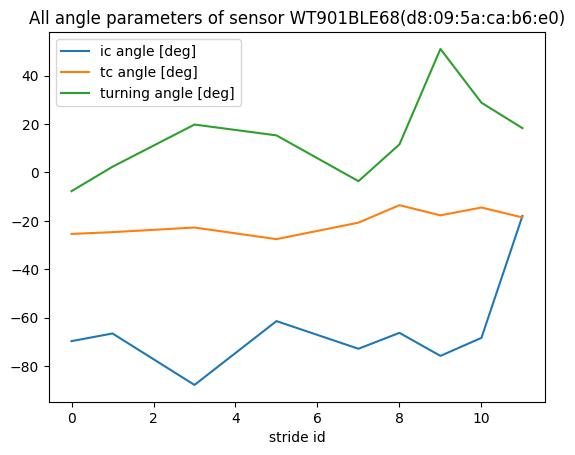

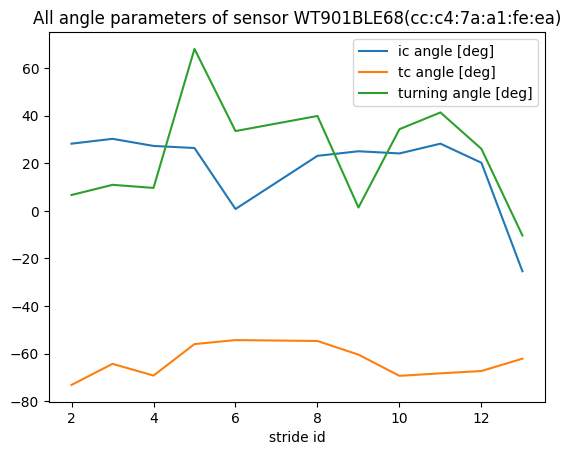

In [76]:
for k, v in spatial_paras.parameters_pretty_.items():
    v.filter(like="angle").plot()
    plt.title(f"All angle parameters of sensor {k}")

In [78]:
for k, v in spatial_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(d8:09:5a:ca:b6:e0)            arc length [m]  gait velocity [m/s]  ic angle [deg]  \
stride id                                                        
0                3.685318             0.047402      -69.701184   
1                5.095438             0.070945      -66.539517   
3                3.439665             0.041742      -87.801228   
5                1.558320             0.036815      -61.423115   
7                4.419465             0.057678      -72.853751   
8                5.277295             0.053745      -66.279250   
9                5.813625             0.040025      -75.802294   
10               5.605099             0.052836      -68.343302   
11               2.315108             0.051999      -18.000522   

           max. lateral excursion [m]  max. orientation change [deg]  \
stride id                                                              
0                            0.001683                      66.678670   
1                          

In [77]:
for k, v in temporal_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(d8:09:5a:ca:b6:e0)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
0                     2.02            0.50             1.52
1                     1.86            0.56             1.30
3                     1.84            0.38             1.46
5                     1.62            0.26             1.36
7                     2.08            0.64             1.44
8                     1.98            0.52             1.46
9                     2.20            0.68             1.52
10                    2.06            0.58             1.48
11                    1.52            0.02             1.50
WT901BLE68(cc:c4:7a:a1:fe:ea)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
2                     1.82            0.58             1.24
3                     1.84            0.62             1.22
4                     1.98            0.